# Lab 1 - ARIMA+NN

1. (2 points) Apply ARIMA model for forecasting. Explain the choice of p,d,q paramters. Did you
notice anything strange?
2. (3 points) Implement LSTM architectures for the given dataset. Estimate its performance.
3. (3 points) Implement TSS architectures for the given dataset. Estimate its performance.
4. (2 points) Compare results of the algorithms.

In [1]:
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
train = np.load(join("data", "train.npy"))
test = np.load(join("data", "test.npy"))

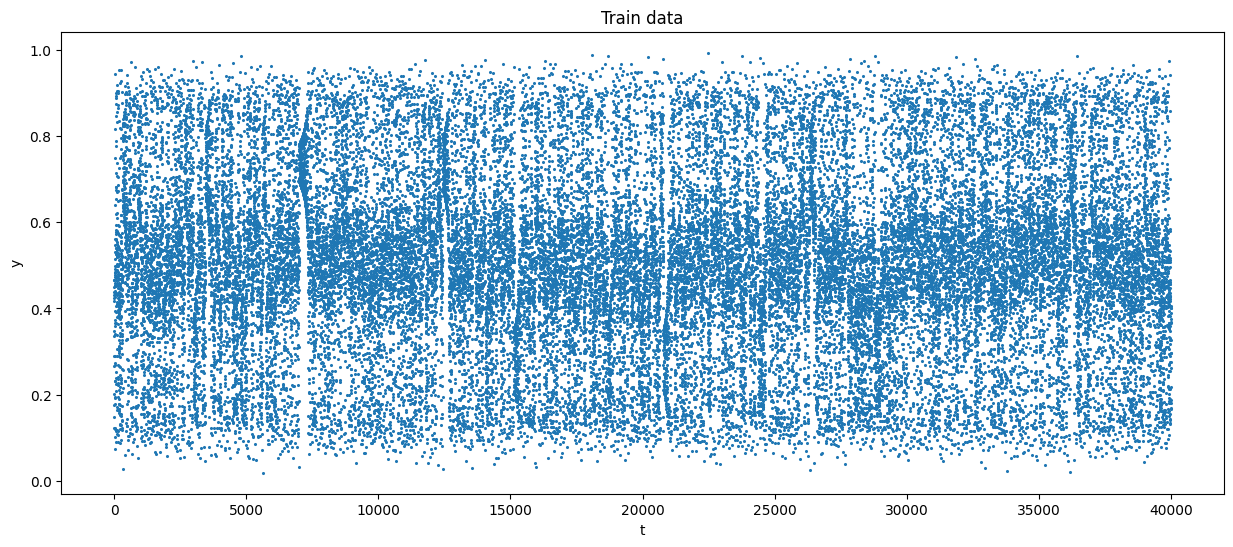

In [3]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(40_000), train, s=1.5)
plt.title("Train data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

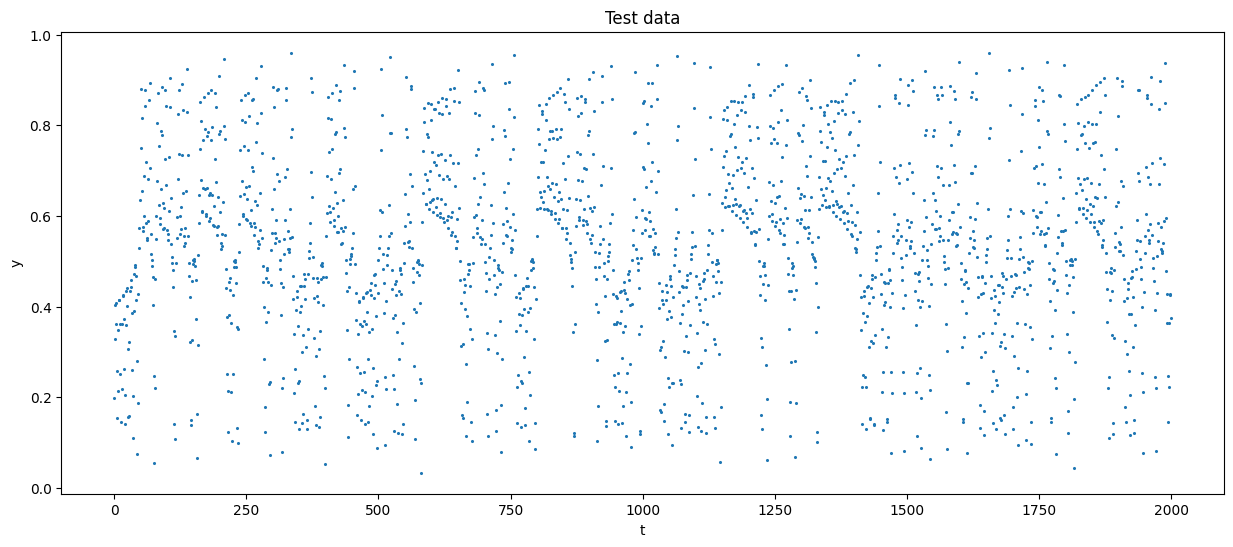

In [4]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(2_000), test, s=1.5)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

In [5]:
def acf(series: np.ndarray, k: int) -> float:
    mean = np.mean(series)
    return ((series[k:] - mean) * (series[:-k] - mean)).sum() / np.pow(series - mean, 2).sum()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 11047.09it/s]


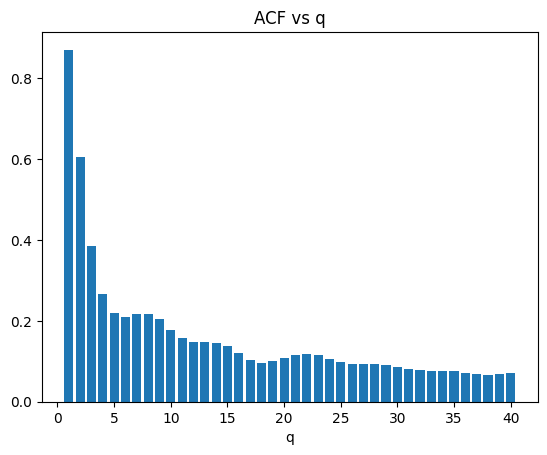

In [6]:
from tqdm import trange

k = 40

acf_data = [acf(train, i) for i in trange(1, k+1)]
plt.bar(np.arange(1, k + 1), acf_data[:k])
plt.title("ACF vs q")
plt.xlabel("q")
plt.show()

According to the graph `q` should be equal to 3

In [23]:
1024 // 64

16

In [41]:
def get_batched_data(data, batch_size):
    split_idx = [i * batch_size for i in range(batch_size, data.shape[0] // batch_size)]
    if data.shape[0] % batch_size:
        split_idx = split_idx[:-1]
    return np.split(data, split_idx)

In [62]:
from numpy.lib.stride_tricks import sliding_window_view

class AR(BaseEstimator, RegressorMixin):
    def __init__(self, p: int, lr: float = 1e-1, max_iter: int = 100, tol: float = 1e-7, batch_size: int = 32):
        self.weights_ = np.random.normal(size=(p,))
        self.bias_ = np.random.normal()
        self.order = (p,)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.batch_size_ = batch_size
        if self.batch_size_ < self.order[0]:
            raise ValueError(f"Batch size {batch_size} smaller than order {p}")

    def fit(self, X):
        p = self.order[0]
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}. "
        self.loss_hist_ = []
        X_batched = get_batched_data(X, self.batch_size_)
        for i in range(self.max_iter_):
            for x_batch in X_batched:
                resid = x_batch[p:] - sliding_window_view(x_batch[:-1], p) @ self.weights_ - self.bias_
                self.bias_ += self.lr_ * resid.mean()
                self.weights_ += self.lr_ * (resid @ sliding_window_view(x_batch[:-1], p)) / resid.shape[0]
                loss = (resid**2).mean()
                self.loss_hist_.append(loss)
                if i != 0:
                    if np.abs(loss - prev_loss) < self.tol_:
                        self.convergence_message = "Successfully converged. "
                        break
                prev_loss = loss
        self.convergence_message += f"Loss: {loss:0.4f}"
        return self

    def predict(self, X):
        p = self.order[0]
        return X[-p:] @ self.weights_ + self.bias_

Successfully converged. Loss: 0.0043


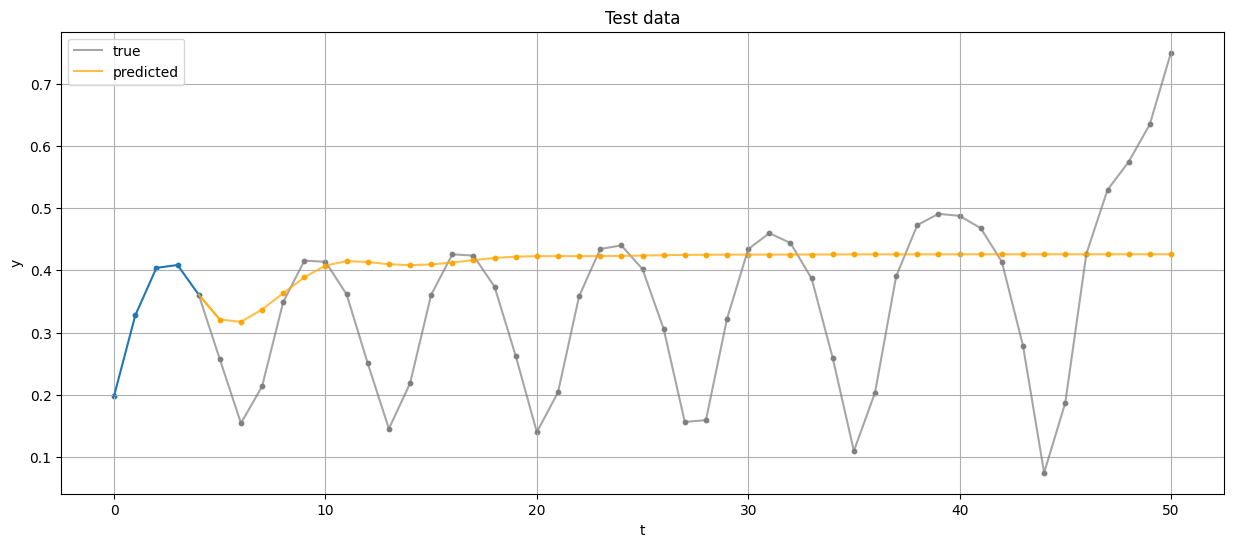

In [69]:
k = 50
p = 5

ar = AR(p).fit(train)
ar_preds = test[:p].copy()
print(ar.convergence_message)

for i in range(0, k - p + 1):
    pred = ar.predict(ar_preds)
    ar_preds = np.append(ar_preds, pred)

# ar_preds = np.array([ar.predict(train[:i + p]) for i in range(0, k - p + 1)])

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, p), test[:p], s=10)
plt.plot(np.arange(0, p), test[:p])
plt.scatter(np.arange(p, k+1), test[p:k+1], s=10, c="grey")
plt.plot(np.arange(p-1, k+1), test[p-1:k+1], c="grey", alpha=.7, label = "true")
plt.scatter(np.arange(p, k+1), ar_preds[p:k+1], s=10, c="orange")
plt.plot(np.arange(p-1, k+1), ar_preds[p-1:k+1], c="orange", alpha=.7, label="predicted")
plt.plot([p-1, p], ar_preds[p-1:p+1], c="orange", alpha=.7)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

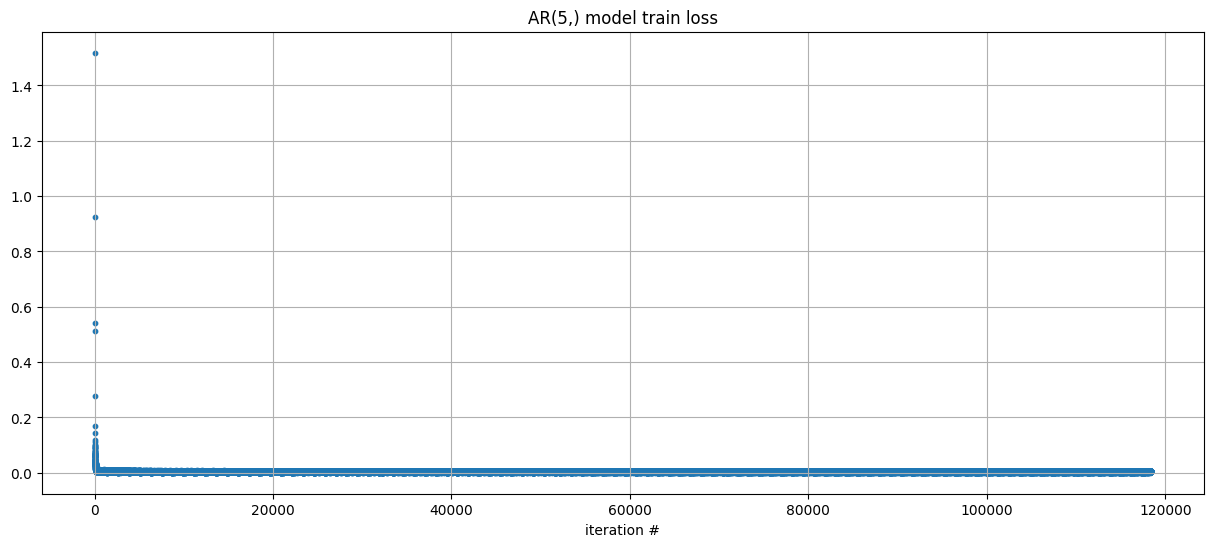

In [70]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, len(ar.loss_hist_)), ar.loss_hist_, s=10)
plt.title(f"AR{ar.order} model train loss")
plt.xlabel("iteration #")
plt.grid()
plt.show()

In [67]:
def pacf(series: np.ndarray, p: int) -> float:
    linreg = AR(p).fit(series)
    return linreg.weights_[0]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/it]


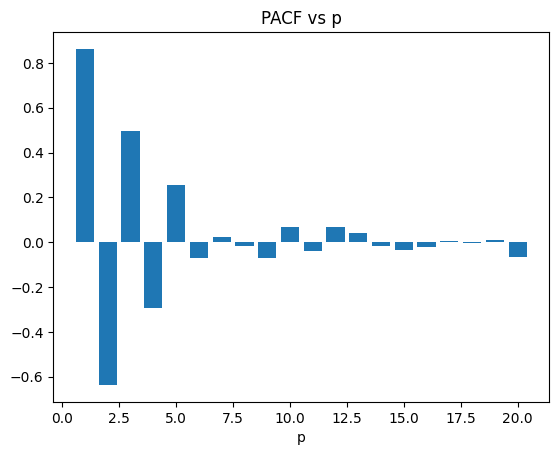

In [68]:
from tqdm import trange

k = 20
pacf_data = [pacf(train, i) for i in trange(1, k+1)]

plt.bar(np.arange(1, k+1), pacf_data[:k])
plt.title("PACF vs p")
plt.xlabel("p")
plt.show()

The PACF plot suggests that `p` should be equal to 5, since it experiences a sharp breakoff

In [125]:
import warnings

from tqdm import tqdm

warnings.filterwarnings("error")

class ARMA(BaseEstimator, RegressorMixin):
    def __init__(self, q: int, lr: float = 1e-6, max_iter: int = 100, tol: float = 1e-7, batch_size: int = 32):
        self.weights_ = np.random.normal(size=(p,))
        self.residual_weights_ = np.random.normal(size=(q,))
        self.bias_ = np.random.normal()
        self.order = (p, q)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.batch_size_ = batch_size
        if self.batch_size_ < max(self.order):
            raise ValueError(f"Batch size {batch_size} too small for order {self.order}")

    def AR_iter(self, x_batch) -> None:
        p, _ = self.order
        resid = x_batch[p:] - sliding_window_view(x_batch[:-1], p) @ self.weights_
        self.weights_ += self.lr_ * (resid @ sliding_window_view(x_batch[:-1], p)) / resid.shape[0]
        return None

    def MA_iter(self, res_batch) -> None:
        _, q = self.order
        resid = res_batch[q:] - sliding_window_view(res_batch[:-1], q) @ self.residual_weights_ - self.bias_
        self.residual_weights_ += self.lr_ * (resid @ sliding_window_view(res_batch[:-1], q)) / resid.shape[0]
        self.bias_ += self.lr_ * resid.mean()
        return None

    def fit(self, X):
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}. "
        self.loss_hist_ = []
        p, q = self.order
        X_batched = get_batched_data(X, self.batch_size_)
        for i in range(self.max_iter_):
            for bid, x_batch in enumerate(tqdm(X_batched)):
                if x_batch.shape[0] > max(self.order):
                    self.AR_iter(x_batch)
                    resid_ar = x_batch[p:] - sliding_window_view(x_batch[:-1], p) @ self.weights_
                    self.MA_iter(resid_ar)
                    resid_arma = resid_ar[q:] - sliding_window_view(resid_ar[:-1], q) @ self.residual_weights_ - self.bias_
                    try:
                        loss = (resid_arma**2).mean()
                    except:
                        print(f"Epoch #{i}. Batch #{bid}")
                        print(resid_ar[-10:])
                        print(resid_arma[-10:])
                        break
                    self.loss_hist_.append(loss)
                    if i != 0:
                        if np.abs(loss - prev_loss) < self.tol_:
                            self.convergence_message = "Successfully converged. "
                            break
                    prev_loss = loss

            else:
                continue
            break
        self.residuals = resid_ar[-q:]
        self.convergence_message += f"Loss: {loss:0.4f}"
        return self

    def predict(self, X):
        p, q = self.order
        return X[-p:] @ self.weights_ + self.residuals @ self.residual_weights_ + self.bias_

In [127]:
k = 50
p = 5
q = 3
window_size = max(p, q)

arma = ARMA(p, q).fit(train)
arma_preds = test[:window_size].copy()
print(arma.convergence_message)

for i in range(0, k - window_size + 1):
    pred = arma.predict(arma_preds)
    arma_preds = np.append(arma_preds, pred)

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, window_size), test[:window_size], s=10)
plt.plot(np.arange(0, window_size), test[:window_size])
plt.scatter(np.arange(window_size, k+1), test[window_size:k+1], s=10, c="grey")
plt.plot(np.arange(window_size-1, k+1), test[window_size-1:k+1], c="grey", alpha=.7, label = "true")
plt.scatter(np.arange(window_size, k+1), arma_preds[window_size:k+1], s=10, c="orange")
plt.plot(np.arange(window_size-1, k+1), arma_preds[window_size-1:k+1], c="orange", alpha=.7, label="predicted")
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

  1%|█▉                                                                                                                             | 18/1219 [00:00<00:00, 9482.22it/s]

Epoch #0. Batch #18
[1459184.18521616 1723018.07446372 2111365.6331855  2335440.53177381
 2316414.11223208 2078371.1156184  1658128.31773992 1407277.93230309
 1392589.78255888 1508448.88471716]
[-8.85922370e+159 -8.21304074e+159 -8.00354783e+159 -8.55915919e+159
 -9.57265518e+159 -1.05911608e+160 -1.12485148e+160 -1.11695936e+160
 -1.04081525e+160 -9.39618566e+159]
Terminated after max_iter=100. Loss: 248248583736392439494201845839790042128677402320291699901797449337443669719156040255748035661085124810791783804042005191769514548518931619559637078051816285600384543364991476377000628729402967792296785243180031152973188078750701755128163123225848618913963901602374872116246740663705743709437952.0000


RuntimeWarning: overflow encountered in matmul

In [117]:
class ARIMA(BaseEstimator, RegressorMixin):
    def __init__(self, p: int, q: int, d: int, lr: float = 1e-5, max_iter: int = 1_000, tol: float = 1e-7, verbose: bool = False):
        super().__init__()
        self.value_weights_ = np.random.normal(size=(p,))
        self.residual_weights_ = np.random.normal(size=(q,))
        self.bias_ = np.random.normal()
        self.order = (p, q, d)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.verbose_ = verbose

    def get_diffs(self, X, d):
        for _ in range(d):
            X = np.diff(X)
        return X

    def get_inverse_diffs(self, y_base, diff_pred, d):
        result = np.array(diff_pred, dtype=float)
        for _ in range(d):
            result = np.r_[y_base[-1], result].cumsum()
            last_values = result
        return result[d:]

    def fit(self, X):
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}"
        loss_hist = []
        p, q, d = self.order

        X_diffs = self.get_diffs(X, d)

        for i in range(self.max_iter_):
            residuals = X_diffs[p:] - sliding_window_view(X_diffs[:-1], p) @ self.value_weights_
            self.value_weights_ += self.lr_ * (residuals @ sliding_window_view(X_diffs[:-1], p)) / residuals.shape[0]

            ar_residuals = X_diffs[p:] - sliding_window_view(X_diffs[:-1], p) @ self.value_weights_
            self.diffs = ar_residuals[q:] - sliding_window_view(ar_residuals[:-1], q) @ self.residual_weights_ - self.bias_
            self.bias_ += self.lr_ * self.diffs.mean()
            self.residual_weights_ += self.lr_ * (self.diffs @ sliding_window_view(ar_residuals[:-1], q)) / self.diffs.shape[0]

            loss = (self.diffs**2).mean()
            loss_hist.append(loss)
            try:
                if np.abs(loss - prev_loss) < self.tol_:
                    self.convergence_message = "Successfully converged"
                    break
            except:
                pass
            prev_loss = loss
        self.convergence_message += f" loss: {loss:0.4f}"
        return self

    def predict(self, X):
        p, q, d = self.order
        X_diffs = self.get_diffs(X, d)
        diff_pred = self.diffs[-q:] @ self.residual_weights_ + X_diffs[-p:] @ self.value_weights_ + self.bias_
        return self.get_inverse_diffs(X, diff_pred, d)

Terminated after max_iter=1000 loss: 79.0669
(31,)


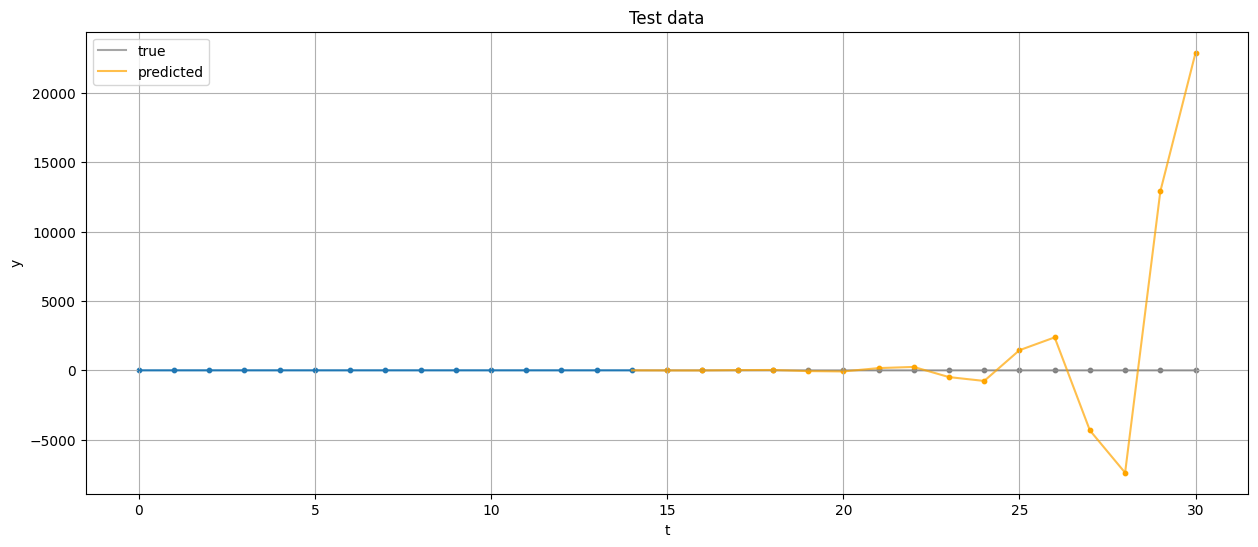

In [126]:
k = 30
p = 5
q = 3
d = 0
window_size = max(p+d, q+d)

arima = ARIMA(p, q, d).fit(train)
arima_preds = test[:window_size].copy()
print(arima.convergence_message)

for i in range(0, k - window_size + 1):
    pred = arima.predict(arima_preds)
    arima_preds = np.append(arima_preds, pred)

print(arima_preds.shape)

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, window_size), test[:window_size], s=10)
plt.plot(np.arange(0, window_size), test[:window_size])
plt.scatter(np.arange(window_size, k+1), test[window_size:k+1], s=10, c="grey")
plt.plot(np.arange(window_size-1, k+1), test[window_size-1:k+1], c="grey", alpha=.7, label = "true")
plt.scatter(np.arange(window_size, k+1), arima_preds[window_size:k+1], s=10, c="orange")
plt.plot(np.arange(window_size-1, k+1), arima_preds[window_size-1:k+1], c="orange", alpha=.7, label="predicted")
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

In [121]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

class ARIMARegressor(BaseEstimator, RegressorMixin):
    """
    Minimal ARIMA(p,d,q) implementation from scratch.
    Uses:
      - differencing for integration (d)
      - ordinary least squares for AR(p)
      - iterative residual substitution for MA(q)
    """

    def __init__(self, order=(1, 0, 0), max_iter=50):
        self.order = order
        self.max_iter = max_iter
        self.ar_params_ = None
        self.ma_params_ = None
        self.d_ = None
        self.train_ = None
        self.resid_ = None

    def _difference(self, y, d):
        for _ in range(d):
            y = np.diff(y)
        return y

    def _inverse_difference(self, last_values, diff_forecast, d):
        result = np.array(diff_forecast, dtype=float)
        for _ in range(d):
            result = np.r_[last_values[-1], result].cumsum()
            last_values = result
        return result[d:] if d > 0 else result

    def _fit_ar(self, y, p):
        if p == 0:
            return np.array([])
        Y = y[p:]
        X = np.column_stack([y[p - k - 1 : -k - 1] for k in range(p)])
        params = np.linalg.lstsq(X, Y, rcond=None)[0]
        return params

    def _fit_ma(self, resid, q):
        if q == 0:
            return np.array([])
        ma_params = np.zeros(q)
        for _ in range(self.max_iter):
            eps = resid.copy()
            for t in range(q, len(resid)):
                eps[t] -= np.dot(ma_params, eps[t-q:t][::-1])
            # OLS update
            E = eps[q:]
            Z = np.column_stack([eps[q-k-1:-k-1] for k in range(q)])
            ma_params = np.linalg.lstsq(Z, E, rcond=None)[0]
        return ma_params

    def fit(self, y, X=None):
        y = np.asarray(y, dtype=float)
        p, d, q = self.order

        yd = self._difference(y, d)
        self.train_ = y
        self.d_ = d

        ar_params = self._fit_ar(yd, p)

        # compute residuals after AR fit
        if p > 0:
            Y = yd[p:]
            X = np.column_stack([yd[p - k - 1 : -k - 1] for k in range(p)])
            ar_pred = X @ ar_params
            resid = Y - ar_pred
        else:
            resid = yd

        ma_params = self._fit_ma(resid, q)

        self.ar_params_ = ar_params
        self.ma_params_ = ma_params
        self.resid_ = resid
        return self

    def predict(self, X=None, n_periods=1):
        p, d, q = self.order
        y = self.train_.copy()

        # Work with differenced space
        yd = self._difference(y, d)
        res = list(self.resid_)

        forecasts = []
        for _ in range(n_periods):
            # AR forecast
            if p > 0:
                ar_term = np.dot(self.ar_params_, yd[-p:][::-1])
            else:
                ar_term = 0.0

            # MA forecast
            if q > 0:
                ma_term = np.dot(self.ma_params_, res[-q:][::-1])
            else:
                ma_term = 0.0

            f = ar_term + ma_term
            forecasts.append(f)

            yd = np.append(yd, f)
            res.append(0.0)

        # invert differencing
        final = self._inverse_difference(self.train_, forecasts, d)
        return np.asarray(final)


(31,)


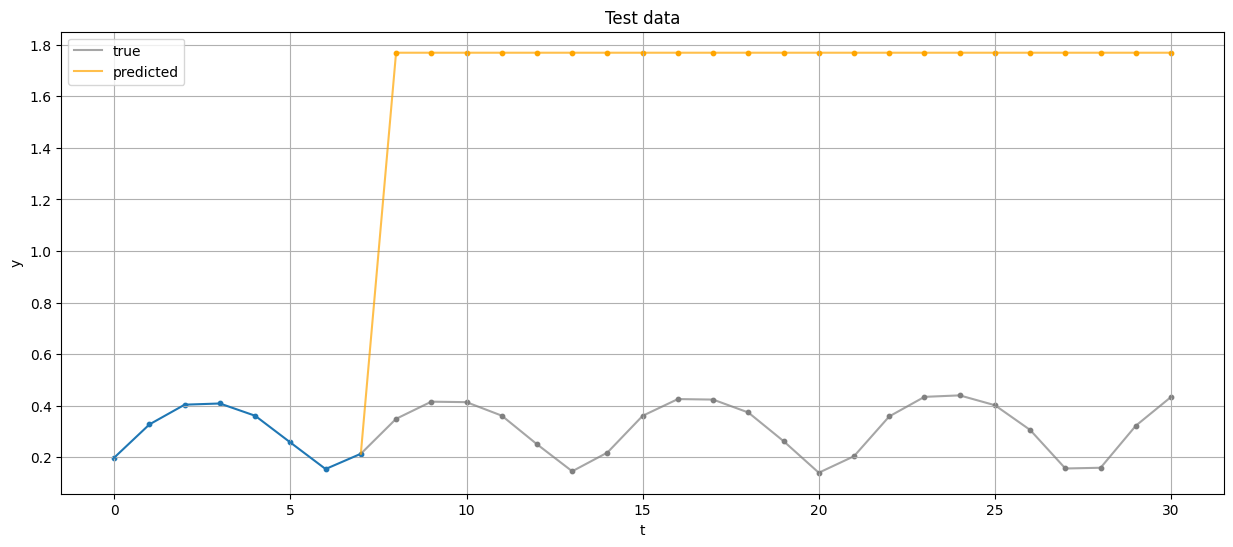

In [124]:
k = 30
p = 5
q = 3
d = 3
window_size = max(p+d, q+d)

arima = ARIMARegressor(order=(p, q, d)).fit(train)
arima_preds = test[:window_size].copy()

for i in range(0, k - window_size + 1):
    pred = arima.predict(arima_preds)
    arima_preds = np.append(arima_preds, pred)

print(arima_preds.shape)

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, window_size), test[:window_size], s=10)
plt.plot(np.arange(0, window_size), test[:window_size])
plt.scatter(np.arange(window_size, k+1), test[window_size:k+1], s=10, c="grey")
plt.plot(np.arange(window_size-1, k+1), test[window_size-1:k+1], c="grey", alpha=.7, label = "true")
plt.scatter(np.arange(window_size, k+1), arima_preds[window_size:k+1], s=10, c="orange")
plt.plot(np.arange(window_size-1, k+1), arima_preds[window_size-1:k+1], c="orange", alpha=.7, label="predicted")
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

In [131]:
k = 30
p = 15
q = 3
d = 0
window_size = max(p+d, q+d)

arima = ARIMA(p, q, d).fit(train)
arima_preds = test[:window_size].copy()
# print(arima.convergence_message)

for i in range(0, k - window_size + 1):
    pred = arima.forecast(arima_preds)
    arima_preds = np.append(arima_preds, pred)

print(arima_preds.shape)

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, window_size), test[:window_size], s=10)
plt.plot(np.arange(0, window_size), test[:window_size])
plt.scatter(np.arange(window_size, k+1), test[window_size:k+1], s=10, c="grey")
plt.plot(np.arange(window_size-1, k+1), test[window_size-1:k+1], c="grey", alpha=.7, label = "true")
plt.scatter(np.arange(window_size, k+1), arima_preds[window_size:k+1], s=10, c="orange")
plt.plot(np.arange(window_size-1, k+1), arima_preds[window_size-1:k+1], c="orange", alpha=.7, label="predicted")
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

ValueError: negative dimensions are not allowed